# GoBike scheme analysis

Date created: 3 Oct 2022

This is a preliminary analysis on the acquisition and expansion strategies for the Ford GoBike scheme. GoBike is a regional bike share scheme in the San Francisco Bay Area. The scheme is operated by Motivate and has been rebranded as Bay Wheels since 2019 after acquisition by Lyft. The dataset is available as a [Google Big Query public dataset](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=san_francisco_bikeshare&page=dataset).

Although the dataset has multiple tables, this analysis is focused on the bikeshare_trips table. The bike availability table (bikeshare_station_status) is real time and thus exists in a different market context. 

Since the trips table only records trips dated 2013-2018, this analysis will be based on the market context in the period, specifically from 2016 to 2018. 

In [1]:
from dask.distributed import Client, TimeoutError, LocalCluster

# spin up local cluster to use all cores on your local machine

cluster = LocalCluster(n_workers=8, threads_per_worker=1, memory_limit = '64GB')

client = Client(cluster)

print(cluster.scheduler)

<Scheduler: "tcp://127.0.0.1:53723" processes: 8 cores: 8>


In [13]:
# analysis 

#analysis period: 2016-06-01 - 2018-05-01 (24 months)

import os
from google.cloud import bigquery
import modin.pandas as mpd
import pandas_gbq
from google.oauth2 import service_account
from shapely.geometry import Point
import time
import googlemaps
import datetime
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

import multiprocess as mp

import plotly.graph_objects as go
from matplotlib.ticker import FuncFormatter

# to display figure while offline
from plotly.offline import iplot

# authenticate

credentials = service_account.Credentials.from_service_account_file('bikeshare_service_key.json')
pandas_gbq.context.credentials = credentials

pandas_gbq.context.project = None # to be filled in

map_api_key = None # to be filled

gmaps = googlemaps.Client(key=map_api_key)


### Getting data from Big Query

Since processing 5 years of bike trip data imposes a high demand on memory, I queried 24 months of data as if this analysis was done in mid-2018. The resulting dataset is still quite big for a single machine (~1 million). I used modin and the multiprocess library throughout for parallel processing (need to spin up a cluster on local machine).

In [165]:
# all trips dataaset

t1 = time.time()

all_trips = mpd.read_gbq("""
SELECT t.*
FROM `moonlit-web-230506.san_francisco_ford_gobike_share.bikeshare_trips` t
WHERE t.start_date >= '2016-05-01' AND t.start_date < '2018-05-01'
""")

t_query = time.time() - t1

print('Time taken: {:.0f}min {:.0f}sec'.format(t_query//60, t_query%60))



Time taken: 7min 12sec


In [79]:
print('No. of trips within the period: {:,}'.format(len(set(all_trips.trip_id))))

No. of trips within the period: 1,049,693


In [6]:
print('No. of trips without either one of station coordinates: {:,}'.format(all_trips[(all_trips['start_station_latitude'].isna()) | (all_trips['end_station_latitude'].isna())].trip_id.nunique()))

No. of trips without either one of station coordinates: 114,244


### Data preprocessing

1. Coordinates 
- Around 10% of stations do not have a coordinate. However, the bikeshare_station_info (station) table and the bikeshare_trips (trips) table cannot be joined by station_id as they have different formats. While many names coincide, some names in the trips table cannot be found in the station table. I fill in the missing coordinates in the trips table whenever the station is found in the station table. 

2. Calculate duration 

3. Calculate distance 
- By calling the Google distance matrix API, set _mode_ as 'bicycling' to get the most probable bike route between two points.
- Beware of charges of API calls, I learnt the hard way!

4. Clean subscriber columns 
- For some reason, the two columns, subscriber_type and c_subscription_type, each contains the subscriber value when the other column is null. Need to unify these two columns to get one subscriber value.

In [80]:
# station table

t1 = time.time()

station_info = mpd.read_gbq("""
SELECT *
FROM `moonlit-web-230506.san_francisco_ford_gobike_share.bikeshare_station_info` 
WHERE name in ('Cyril Magnin St at Ellis St', 'San Pedro Square', 'San Jose City Hall', 'Ryland Park')
""")

t_query = time.time() - t1

print('Time taken: {:.0f}min {:.0f}sec'.format(t_query//60, t_query%60))

c:\Users\WingyanYip\anaconda3\lib\site-packages\modin\error_message.py:64: UserWarning:

`read_gbq` defaulting to pandas implementation.



Time taken: 0min 2sec


In [ ]:
# join the two tables 

trips_df = all_trips.merge(station_info[['name', 'lat', 'lon']], how='left', left_on='start_station_name', right_on='name', copy=False, validate='many_to_one')
trips_df.rename(columns={'lat':'start_lat', 'lon':'start_lon'}, inplace=True)
trips_df.drop(columns='name', inplace=True)

trips_df = trips_df.merge(station_info[['name', 'lat', 'lon']], how='left', left_on='end_station_name', right_on='name', copy=False, validate='many_to_one')
trips_df.rename(columns={'lat':'end_lat', 'lon':'end_lon'}, inplace=True)
trips_df.drop(columns='name', inplace=True)

# fill the missing lon/ lat with coordinates from the station table. 

trips_df['clean_start_lat'] = np.where(((trips_df['start_station_latitude'].isna()) & (~trips_df['start_lat'].isna())), trips_df['start_lat'], trips_df['start_station_latitude'])
trips_df['clean_start_lon'] = np.where(((trips_df['start_station_longitude'].isna()) & (~trips_df['start_lon'].isna())), trips_df['start_lon'], trips_df['start_station_longitude'])

trips_df['clean_end_lat'] = np.where(((trips_df['end_station_latitude'].isna()) & (~trips_df['end_lat'].isna())), trips_df['end_lat'], trips_df['end_station_latitude'])
trips_df['clean_end_lon'] = np.where(((trips_df['end_station_longitude'].isna()) & (~trips_df['end_lon'].isna())), trips_df['end_lon'], trips_df['end_station_longitude'])



In [172]:
# calculate duration 

trips_df['duration_min'] = trips_df['end_date'] - trips_df['start_date']
trips_df['duration_min'] = trips_df['duration_min'].astype('timedelta64[m]')

In [173]:
# calculate distance
# step 1: get a set of unique start-end station combo so to reduce the calls to the distance matrix API
start_end_coords = trips_df.groupby(['start_station_name', 'end_station_name'], as_index=False).agg(
                                                                                clean_start_lat = ('clean_start_lat', 'mean'), 
                                                                                clean_start_lon = ('clean_start_lon', 'mean'),
                                                                                clean_end_lat = ('clean_end_lat', 'mean'),
                                                                                clean_end_lon = ('clean_end_lon', 'mean'))

start_end_coords = start_end_coords[~start_end_coords['clean_start_lat'].isna()]

start_end_coords.shape

(25077, 6)

In [174]:
startcoord = [(lat, lon) for lat, lon in zip(start_end_coords['clean_start_lat'], start_end_coords['clean_start_lon'])]
endcoord = [(lat, lon) for lat, lon in zip(start_end_coords['clean_end_lat'], start_end_coords['clean_end_lon'])]

In [175]:
# step 2: a function to calculate distance

def cal_dist(start_lst, end_lst):
    import googlemaps, numpy as np
    map_api_key = None # to be filled in 
    gmaps = googlemaps.Client(key=map_api_key)
    result = gmaps.distance_matrix(start_lst, end_lst, mode='bicycling', units='metric')
    if 'distance' in result['rows'][0]['elements'][0].keys():
        return result['rows'][0]['elements'][0]['distance']['value']
    else: 
        return np.nan

In [ ]:
cur_results = []

In [ ]:
# step 3: call the distance matrix api
# put small set of coordinates in each call to prevent authentication error. 

results = []

start_time = time.time()

tot = len(startcoord)
step = 500
last_end = len(cur_results)

# for pos in range(0, len(endcoord), 100):
for pos in range(last_end, tot, step):

    start = time.time()

    with mp.Pool(processes=7) as pool:
        results.extend(pool.starmap(cal_dist, zip(startcoord[pos:pos + step], endcoord[pos:pos + step])))

    time_taken = time.time() - start

    print('Time taken: {:.0f}min {:.0f}sec'.format(time_taken//60, time_taken%60))

total_time = time.time() - start_time

print('finished, total time :{:.0f}min {:.0f}sec'.format(total_time//60, total_time%60))

In [178]:
len(results)

25077

In [181]:
# step 4: add the distance column to the original dataframe (trips_df)

start_end_coords['distance_m'] = results

trips_df= trips_df.merge(start_end_coords[['start_station_name', 'end_station_name', 'distance_m']], how='left', 
                on=['start_station_name', 'end_station_name'], copy=False, validate='m:1')

In [47]:
# 1,268 trips travelled more than 8km

trips_df[trips_df['distance_m']>8000].shape

(1268, 31)

In [49]:
# 99% of trips were under 5,797 m

np.nanpercentile(trips_df['distance_m'], 99)

5797.0

In [ ]:
# combine two columns to get a clean subscriber type

trips_df['clean_subscriber'] = np.where(trips_df['subscriber_type']=='nan', trips_df['c_subscription_type'], trips_df['subscriber_type'])

In [56]:
trips_df['clean_subscriber'].value_counts(dropna=False)

Subscriber    864014
Customer      185679
Name: clean_subscriber, dtype: int64

### Visualisation

1. Distribution of distance travelled by bikers (general and by type)
2. Distribution of duration travelled by bikers (general and by type)
3. Station locations
4. Most popular routes by region (San Francisco, Oakland, San Jose)
5. No. of trips by subscriber type
6. No. of trips by day of the week
7. No. of trips by month of the year

<Figure size 576x576 with 0 Axes>

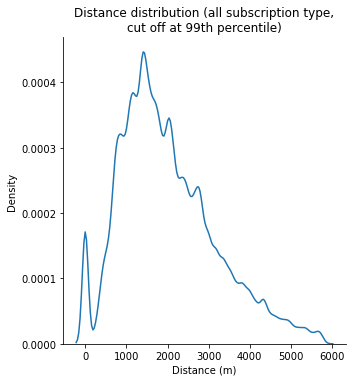

In [182]:
plt.figure(figsize=(8,8))

sns.displot(data=trips_df[trips_df['distance_m'] < np.nanpercentile(trips_df['distance_m'], 99)], x='distance_m', kind='kde')

plt.xlabel('Distance (m)')
plt.title('Distance distribution (all subscription type,\ncut off at 99th percentile)')

plt.show()

<Figure size 576x576 with 0 Axes>

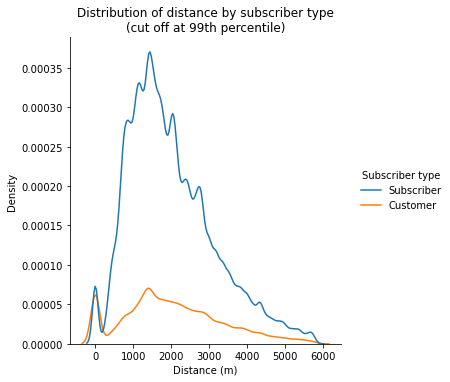

In [187]:
# distribution of distance
# kde tells you the probability of a particular type of subscriber

plt.figure(figsize=(8,8))

g = sns.displot(data=trips_df[trips_df['distance_m'] < np.nanpercentile(trips_df['distance_m'], 99)], x='distance_m', kind='kde', hue='clean_subscriber')
g._legend.set_title('Subscriber type')
plt.title('Distribution of distance by subscriber type\n(cut off at 99th percentile)')
plt.xlabel('Distance (m)')

plt.show()



In [67]:
# understand why so many 0s

print('No. of trips that started and ended at the same stop: {:,}'.format(trips_df[trips_df['distance_m'] == 0].trip_id.nunique()))

No. of trips that started and ended at the same stop: 30,128


In [89]:
# the biker with the longest distance - 89 km!

trips_df[trips_df['distance_m'] == trips_df['distance_m'].max()]

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,c_subscription_type,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,member_birth_year,member_gender,bike_share_for_all_trip,start_station_geom,end_station_geom,start_lat,start_lon,end_lat,end_lon,clean_start_lat,clean_start_lon,clean_end_lat,clean_end_lon,duration_min,distance_m,clean_subscriber
381268,20171110140206.7310001842,27166,2017-11-10 14:02:06.731000+00:00,Santa Clara St at Almaden Blvd,314,2017-11-10 21:34:53.109000+00:00,Laguna St at McAllister St,40,1842,None,Customer,None,37.333988,-121.894902,37.779208,-122.426829,<NA>,None,None,POINT(-121.894902 37.333988),POINT(-122.4268287 37.7792082),NaN,NaN,NaN,NaN,37.333988,-121.894902,37.779208,-122.426829,452.0,88991.0,Customer


In [71]:
# 95% of bikers biked <= 32 mins

np.nanpercentile(trips_df['duration_min'], 95)

32.0

<Figure size 576x576 with 0 Axes>

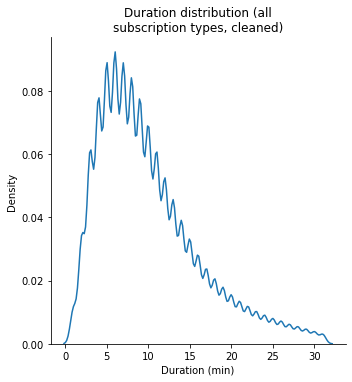

In [188]:
# kde on duration - took out <0 and cut at 95th percentile

plt.figure(figsize=(8,8))

# sns.displot(data=trips_df, x='duration_min', kind='kde')

sns.displot(data=trips_df[(trips_df['duration_min'] < np.nanpercentile(trips_df['duration_min'], 95)) &
                           (trips_df['duration_min'] >0)], x='duration_min', kind='kde')

plt.xlabel('Duration (min)')
plt.title('Duration distribution (all\nsubscription types, cleaned)')

plt.show()

<Figure size 576x576 with 0 Axes>

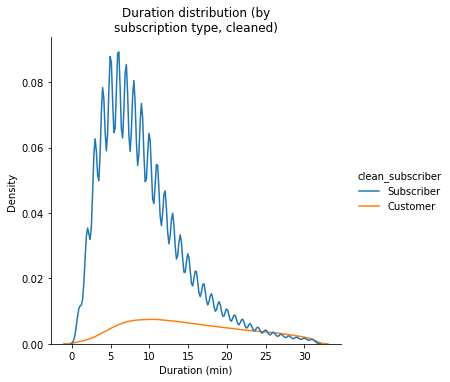

In [189]:
# kde on duration separated by subscription type

plt.figure(figsize=(8,8))

# sns.displot(data=trips_df, x='duration_min', kind='kde', hue='clean_subscriber')

sns.displot(data=trips_df[(trips_df['duration_min'] < np.nanpercentile(trips_df['duration_min'], 95)) &
                        (trips_df['duration_min'] >0)], x='duration_min', hue='clean_subscriber', kind='kde')

plt.xlabel('Duration (min)')
plt.title('Duration distribution (by\nsubscription type, cleaned)')

plt.show()

In [8]:
# get unique set of stations

start_stations = trips_df.groupby(['start_station_name'], as_index=False).agg(lat = ('clean_start_lat', 'mean'), 
                                                                            lon = ('clean_start_lon', 'mean'))
start_stations = start_stations[~start_stations['lat'].isna()]
start_stations.rename(columns={'start_station_name':'station_name'}, inplace=True)
end_stations = trips_df.groupby(['end_station_name'], as_index=False).agg(lat = ('clean_end_lat', 'mean'), 
                                                                        lon = ('clean_end_lon', 'mean'))
end_stations.rename(columns={'end_station_name':'station_name'}, inplace=True)
end_stations = end_stations[~end_stations['lat'].isna()]
                            
station_coords = mpd.concat([start_stations, end_stations])
station_coords.drop_duplicates(inplace=True)

In [191]:
station_coords

,station_name,lat,lon
0,10th Ave at E 15th St,37.792714,-122.248780
1,10th St at Fallon St,37.797673,-122.262997
2,11th St at Bryant St,37.770030,-122.411726
3,11th St at Natoma St,37.773507,-122.416040
4,12th St at 4th Ave,37.795812,-122.255555
...,...,...,...
350,Valencia St at Cesar Chavez St,37.747998,-122.420219
354,W St John St at Guadalupe River Trail,37.335388,-121.897920
359,Webster St at 19th St,37.806970,-122.266588
363,West Oakland BART Station,37.805318,-122.294837


In [6]:
# calculate how many trips per start end combo

start_end_coords = trips_df.groupby(['start_station_name', 'end_station_name'], as_index=False).agg(
                                                                                cnt_trip = ('trip_id', 'nunique'),
                                                                                start_lat = ('clean_start_lat', 'mean'), 
                                                                                start_lon = ('clean_start_lon', 'mean'),
                                                                                end_lat = ('clean_end_lat', 'mean'),
                                                                                end_lon = ('clean_end_lon', 'mean')
                                                                                )



In [15]:
# plot stations on map

fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon = station_coords['lon'],
    lat = station_coords['lat'],
    hoverinfo = 'text',
    text = station_coords['station_name'],
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(53, 94, 59)',
        opacity = .8,
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))


fig.update_layout(
    title_text = 'Stations used in 2016 May - 2018 Apr (Hover to see station names)',
    showlegend = False,
    geo = dict(
        projection_type = "equirectangular",
        coastlinewidth = 2,
        resolution = 50,
        showland = True,
        showlakes = True,
        landcolor = 'rgb(204, 204, 204)',
        countrycolor = 'rgb(204, 204, 204)',
        lakecolor = 'rgb(255, 255, 255)',
        lataxis = dict(
            range = [station_coords['lat'].min()-0.01, station_coords['lat'].max()+0.01],
            showgrid = True,
            dtick = 10
        ),
        lonaxis = dict(
            range = [station_coords['lon'].min()-0.01, station_coords['lon'].max()+0.01],
            showgrid = True,
            dtick = 20
        ),
    ),
)


# fig.show()
iplot(fig)

#### Visualisation: Given four data points that define the quadrilateral of an area, find stations that fall within this rectangle.

This step involves manually defining the four points which form a quadrilateral for each of the three areas on the map: Oakland, San Jose and San Francisco. The station table contains region_id of the station and might save the manual definition. However, the station table and trips table do not have a field which they can join directly. 

In [16]:
# function to get stops which fall within the quadrilateral 

def find_pts(top,down,left,right):
    return start_end_coords[(start_end_coords['start_lat'] < top) & (start_end_coords['start_lat'] > down) & \
                (start_end_coords['start_lon'] < right) & (start_end_coords['start_lon'] > left)]



In [17]:
# find unique stations within the set

def unique_station(frame):
    start_stations = frame.groupby(['start_station_name'], as_index=False).agg(lat = ('start_lat', 'mean'), 
                                                                                lon = ('start_lon', 'mean'))
    start_stations = start_stations[~start_stations['lat'].isna()]
    start_stations.rename(columns={'start_station_name':'station_name'}, inplace=True)
    end_stations = frame.groupby(['end_station_name'], as_index=False).agg(lat = ('end_lat', 'mean'), 
                                                                            lon = ('end_lon', 'mean'))
    end_stations.rename(columns={'end_station_name':'station_name'}, inplace=True)
    end_stations = end_stations[~end_stations['lat'].isna()]
                                
    station_coords = mpd.concat([start_stations, end_stations])
    station_coords.drop_duplicates(inplace=True)

    return station_coords

In [21]:
# visualise the trips

def visualise_trip(frame, station_frame, locale):
    import plotly.graph_objects as go

    fig = go.Figure()
    
    for i in range(len(frame)):
        fig.add_trace(
            go.Scattergeo(
                lon = [frame['start_lon'][i], frame['end_lon'][i]],
                lat = [frame['start_lat'][i], frame['end_lat'][i]],
                mode = 'lines',
                line = dict(width = 1,color = 'rgb(6,78,64)'),
                opacity = float(frame['cnt_trip'][i]) / float(frame['cnt_trip'].max()),
            )
        )

    fig.add_trace(go.Scattergeo(
    lon = station_frame['lon'],
    lat = station_frame['lat'],
    hoverinfo = 'text',
    text = station_frame['station_name'],
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(53, 94, 59)',
        opacity = .8,
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

    fig.update_layout(
        title_text = f'Top 100 trips done in {locale} during 2016 May - 2018 Apr (Hover to see station names)',
        showlegend = False,
        geo = dict(
            projection_type = "equirectangular",
            coastlinewidth = 2,
            resolution = 50,
            showland = True,
            showlakes = True,
            landcolor = 'rgb(204, 204, 204)',
            countrycolor = 'rgb(204, 204, 204)',
            lakecolor = 'rgb(255, 255, 255)',
            lataxis = dict(
                range = [station_frame['lat'].min()-0.01, station_frame['lat'].max()+0.01],
                showgrid = True,
                dtick = 10
            ),
            lonaxis = dict(
                range = [station_frame['lon'].min()-0.01, station_frame['lon'].max()+0.01],
                showgrid = True,
                dtick = 20
            ),
        ),
    )

    iplot(fig)

In [22]:
# Oakland

oakland = find_pts(37.88,37.77,-122.29,-122.21)

oakland = oakland.sort_values('cnt_trip', ascending=False).head(100)

oakland_stations = unique_station(oakland)

c:\Users\WingyanYip\anaconda3\lib\site-packages\modin\error_message.py:64: UserWarning:

sort_values defaulting to pandas implementation.



In [23]:
visualise_trip(oakland, oakland_stations, 'Oakland')


In [24]:
# San Francisco

sf= find_pts(37.78,37.74,-122.44,-122.39)

sf = sf.sort_values('cnt_trip', ascending=False).head(100)

sf_stations = unique_station(sf)

c:\Users\WingyanYip\anaconda3\lib\site-packages\modin\error_message.py:64: UserWarning:

sort_values defaulting to pandas implementation.



In [25]:
visualise_trip(sf, sf_stations, 'San Francisco')

In [26]:
# San Jose

sj= find_pts(37.36,37.31,-121.91,-121.87)

sj = sj.sort_values('cnt_trip', ascending=False).head(100)

sj_stations = unique_station(sj)

c:\Users\WingyanYip\anaconda3\lib\site-packages\modin\error_message.py:64: UserWarning:

sort_values defaulting to pandas implementation.



In [27]:
visualise_trip(sj, sj_stations, 'San Jose')

In [208]:
# No. of trips by subscriber type

subscriber = trips_df.groupby(['clean_subscriber']).agg(trip_cnt = ('trip_id', 'nunique'))

In [123]:
trips_df.groupby(['clean_subscriber']).agg(trip_cnt = ('trip_id', 'nunique'))

,trip_cnt
clean_subscriber,
Customer,185679
Subscriber,864014


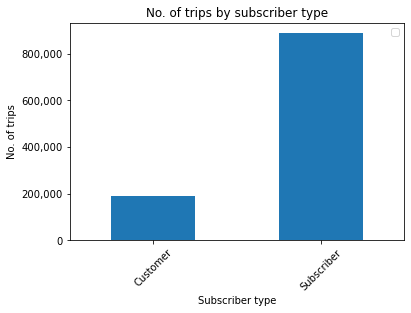

In [209]:
ax = subscriber.plot(kind='bar', rot=45)
ax.get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(int(x), ',')))

plt.title('No. of trips by subscriber type')
plt.xlabel('Subscriber type')
plt.ylabel('No. of trips')
plt.legend([])

plt.show()

In [210]:
# most popular day of the week

day_of_the_week = trips_df['start_date'].dt.day_name()

day_trips = trips_df.groupby(day_of_the_week).agg(cnt_trip=('trip_id', 'nunique'))


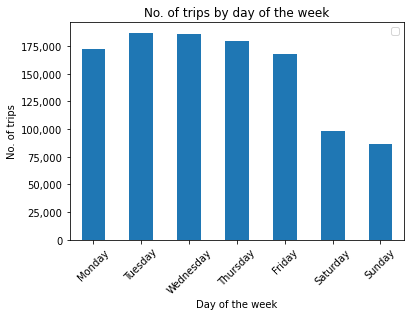

In [211]:
ax = day_trips.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].plot(kind='bar', rot=45)
ax.get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(int(x), ',')))

plt.title('No. of trips by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('No. of trips')
plt.legend([])

plt.show()

In [213]:
months= trips_df['start_date'].dt.month_name()

month_trips = trips_df.groupby(months).agg(cnt_trip=('trip_id', 'nunique'))

In [214]:
# arrange the chart in right order

mnth_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

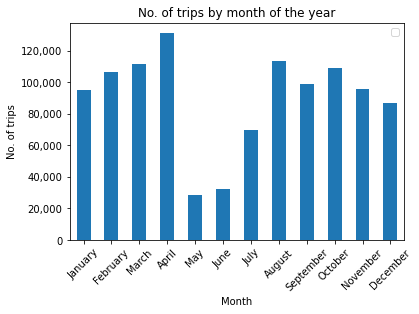

In [215]:
ax = month_trips.loc[mnth_order].plot(kind='bar', rot=45)
ax.get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(int(x), ',')))

plt.title('No. of trips by month of the year')
plt.xlabel('Month')
plt.ylabel('No. of trips')
plt.legend([])

plt.show()

## Analysis

Based on the graphs visualised above, I have five main recommendations:

1. Beachhead targets should be office workers and students
- Based on the no. of trips by day of the week, I hypothesize that the scheme users are office workers/ students. Usage during the weekend is almost half of that during the week. 
- Office workers:
    - Profile: don't want to own/ maintain a bike, health-conscious, young, budget conscious, work from the office (not wrh)
    - Outbound strategies: 
        - Discounts for co-working space users
        - Initiatives with big companies to offer employee discounts
    - Inbound strategies:
        - Brand presence in commercial districts (the most popular bike stops)
            - Billboards
            - Screens in office buildings
        - Linkedin, people who searched for bikes, even office wear
        - Google map ads
- Students:
    - Profile: Undergrads, postgrads, active, budget conscious
    - Outbound strategies:
        - Discounts for students (student discount apps/ sites)
        - Initiatives with big colleges to offer discounts
    - Inbound strategies:
        - Brand presence in college areas
            - Billboards
            - Student brand ambassadors
            - Sponsorship for college events
        - Students who searched for sports-related terms (indicate active lifestyle)
<br>

2. Brand presence at public transport <br>
The bike route visualisation shows that public transport stations (e.g. Diridon station, SF caltrain station, BART stations in Oatkland) are all popular hubs on the bike network. One possible explanation is that users might have biked to the station to get out of town, or train commuters arriving in town might be using bikes for in-town commute. Brand presence at these stations is important to boost visibility and show other transport users a commute alternative.

3. Expand along train stations <br>
Since train stations are major hubs, more bike stops near train stations would meet the demand of users travelling from the stations/ users travelling to the stations looking for a spot to park. 

4. Expand 2km away from the furthest nodes <br>
The distribution of distance travelled by bikers shows that most journeys are between 1-2km. This means when the scheme is expanding, it should consider neighbourhoods that are less than 2km away from the furthest bike stops currently on the map. This is likely to connect neighbourhoods outside the network effectively. 

5. Pricing: free time window for subscribers should be shorter <br>
The distribution of duration travelled by users shown was cut off at the 95th percentile. 95% of the trips done by the scheme users were less than 30 minutes in duration. The scheme during the period (2016-2018), however, only charges $3 for each additional 15 minutes when the trip is over _45_ minutes. The free time window should be reduced to 30 minutes, as this can differentiate around 5% of current trips which can then be charged at a higher price point.

## Limitations

The graphs visualised above only just scratched the surface. More insights can be drawn from, say, station availability to see which bike stops are always empty/ full, so as to add more stops near them. 

However, the data is beset with two main challenges:
- No user ID:
    - There is little information about the user. Much information about user age and gender is missing, while the ZIP code is unreliable, as cautioned by the dataset provider. What is more, there is no user ID which is necessary for user behaviour analysis. This makes it hard to identify, say, traits of users with high bike usage. 
- Trips and station availability exist in different time periods:
    - This means further analysis on station availability e.g. which time of the day it is emptiest/ fullest, is not possible. 

A deck for this can be accessed [here](https://github.com/wy-yip/portfolio/blob/main/gobike_analysis_deck.pdf).